In [2]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import *
import seaborn as sns

from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from textblob import Word

import tensorflow as tf

from keras.src.saving import load_model
from keras.src.models import Model
from keras.src.layers import Dense,Input, Embedding,LSTM,Dropout,Conv1D, MaxPooling1D, GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization,Concatenate, Attention,LayerNormalization, MultiHeadAttention,Add
from keras.src.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.src.optimizers import Adam
from keras.api.preprocessing.sequence import pad_sequences
from keras._tf_keras.keras.preprocessing.text import Tokenizer
from keras import saving

import transformers
import tokenizers


filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_colwidth', None)
plt.style.use("ggplot")
sns.set_palette(sns.diverging_palette(220, 20))

Önsöz giriş yazılacak


The helper functions used in this study are well documented in the utils.py file.

### **1. Data Validation**

In [3]:
df = pd.read_csv("data/IMDB_Dataset.csv")
df.head(2)

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive


Shape of dataset

In [4]:
df.shape

(50000, 2)

Missing Values

In [5]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

Labels

In [6]:
df["sentiment"].value_counts(dropna=False)

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Describe

In [7]:
df.describe().T

,count,unique,top,freq
review,50000,49582,"Loved today's show!!! It was a variety and not solely cooking (which would have been great too). Very stimulating and captivating, always keeping the viewer peeking around the corner to see what was coming up next. She is as down to earth and as personable as you get, like one of us which made the show all the more enjoyable. Special guests, who are friends as well made for a nice surprise too. Loved the 'first' theme and that the audience was invited to play along too. I must admit I was shocked to see her come in under her time limits on a few things, but she did it and by golly I'll be writing those recipes down. Saving time in the kitchen means more time with family. Those who haven't tuned in yet, find out what channel and the time, I assure you that you won't be disappointed.",5
sentiment,50000,2,positive,25000


### **2. Text Preprocessing**

**2.1. Text Cleaning**

Due to its adverse effect on model performance, unwanted punctuation marks, special characters, HTML tags, numbers, and extra spaces have been removed from the comments, and all characters have been converted to lowercase to achieve a clean format.

In [8]:
df["review"] = df["review"].apply(clean_text)

**2.2. Remove Duplicates**

Since identical comments were mixed into the dataset, one instance of each of these comments has been removed from the dataset.

In [9]:
print(f"There are {df["review"].duplicated().sum()} duplicate reviews in imdb dataset")

There are 421 duplicate reviews in imdb dataset


Duplicate Sentences

In [10]:
duplicated_reviews = df[df["review"].duplicated(keep=False)][:2]
duplicated_groups = duplicated_reviews.groupby("review")

for review, group in duplicated_groups:
    print(f"Same sentences:\n {review}")
    print(group)
    print("-" * 100)

Same sentences:
 of all the films i have seen this one the rage has got to be one of the worst yet the direction logic continuity changes in plotscript and dialog made me cry out in pain how could anyone come up with something so crappy gary busey is know for his b movies but this is a sure w movie wwastetake for example about two dozen fbi local law officers surround a trailer house with a jeep wagoneer inside the jeep is ma and is confused as to why all the cops are about within seconds a huge gun battle ensues ma being killed straight off the cops blast away at the jeep with gary and company blasting away at them the cops fall like dominoes and the jeep with gary drives around in circles and are not hit by one single bulletpellet ma is killed and gary seems to not to have noticeddamn that guy is tough truly a miracle not since the sixshooter held bullets has there been such a miracle
                                                                                                    

In [11]:
df.drop_duplicates(inplace=True)
print(f"There are {df["review"].duplicated().sum()} duplicate reviews in imdb dataset")

There are 0 duplicate reviews in imdb dataset


**2.3. Remove Stopwords**

Stopword removal is the process of eliminating common, non-informative words (e.g., "and", "the", "for") from a text to help models focus on more meaningful content.


In [12]:
sw = stopwords.words("english")
df["review"] = df["review"].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

**2.4. Remove Rarewords**

It is undesirable to keep infrequently occurring words in the study. Therefore, their removal is beneficial.

In [13]:
temp_df = pd.Series(" ".join(df["review"]).split()).value_counts().sort_values(ascending=True)
temp_df.head()

filmore            1
whoopass           1
whatchugonnados    1
sheetmetal         1
backhand           1
Name: count, dtype: int64

A threshold of 1000 words has been selected. Words with a frequency of less than 1000 have been removed from the dataset.

In [14]:
rare_words = pd.Series(" ".join(df["review"]).split()).value_counts()[-1000:]
df["review"] = df["review"].apply(lambda x: " ".join(x for x in x.split() if x not in rare_words))

**2.5. Lemmatization**

Lemmatization is the process of reducing a word to its base or dictionary form (lemma), ensuring that different forms of a word (e.g., "running," "ran," "runs") are represented by a single, standardized version, which helps improve the accuracy of natural language processing tasks.


In [15]:
# nltk.download("wordnet")

In [16]:
df["review"] = df["review"].apply(lambda x : " ".join(Word(word).lemmatize() for word in x.split()))

In [17]:
df.sample(2)

,review,sentiment
5995,first movie ever saw ashley judd first film victor nunez ever say boy glad quiet tone relaxed pace realistic depiction young woman starting life fine depiction struggle go make mark life decision make based real thing people meet nothing wrong movie close movie magic ever seen outside star war movie given film like mean film deserves high rating indeed ashley judds acting mr nunezwriting great simple worthwhile story make fine comingofage story wonderful movie,positive
35112,really thought wasnt bad great work art dermot stronger performer far patricia arquette overacting much time actually playing cello impressive line never forced besides incredibly beautiful man really sexy add talent anything he lot tolerable always give even project he involved didnt quite hit highest mark fault actor case he unfortunately strange film didnt resonate box office always alist actor always hit worth every penny dvd rented purchased see wedding date dea messing one best overall film worth every penny havent seen yet youll understand quote,positive


**2.6. Text Preporocess Function**

A function has been written to encompass all the processes mentioned above. Normally, having all tasks contained within a single function is not considered best practice; however, this function has been created specifically for this project and has been added to the `utils.py` file.


### **3. Exploratory data analysis**

**3.1. Countplot of Target**

The dataset contains 49579 reviews after droping duplicates with  28883 positive reviews and 24696 negative reviews. The countplot below illustrates this imbalance.

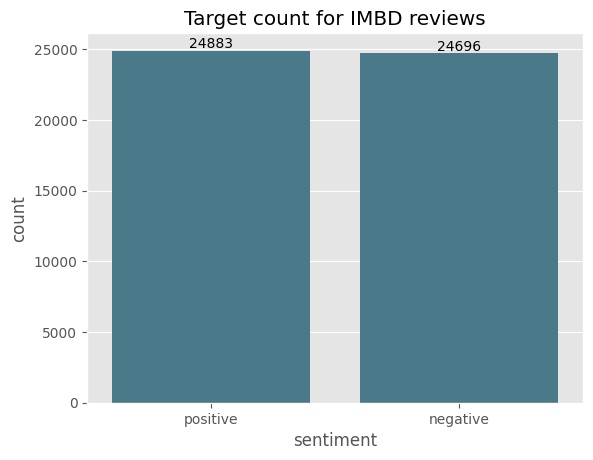

In [18]:
ax = sns.countplot(data=df, x = "sentiment")
plt.title('Target count for IMBD reviews')
ax.bar_label(ax.containers[0], fmt="%d")
plt.show()

**3.2. WordCloud**

A word cloud is a visual representation of the frequency of words in a text. Words that appear more frequently are displayed in larger fonts, while less frequent words are shown in smaller sizes. It is commonly used to quickly identify prominent terms in a dataset, offering a simple way to visualize the importance or repetition of certain words in a document or collection of texts.

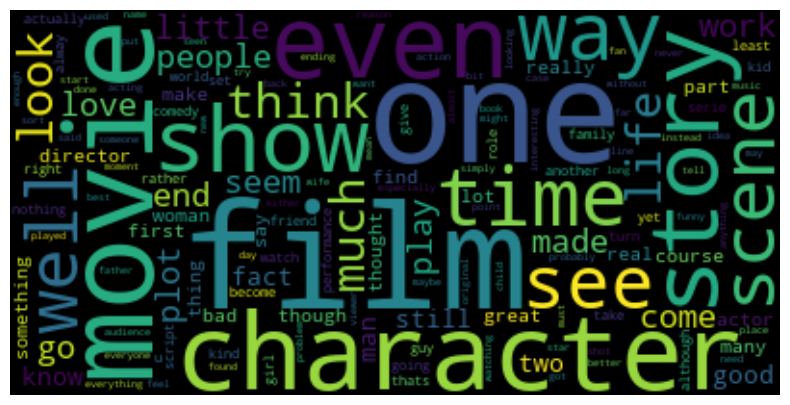

In [19]:
generate_word_cloud(df, "review", max_font_size= 75, max_words = 150 )

**3.2. Distribution of Number of Words Per Reviews**

The words used in negative and positive reviews have been counted and visualized, revealing that people tend to use more words in negative reviews. In both graphs, the rightward skew indicates that certain words are used very frequently in both negative and positive reviews.

In [20]:
positive_reviews = df.loc[df["sentiment"]=="positive", "review"]
negative_reviews = df.loc[df["sentiment"]=="negative", "review"]

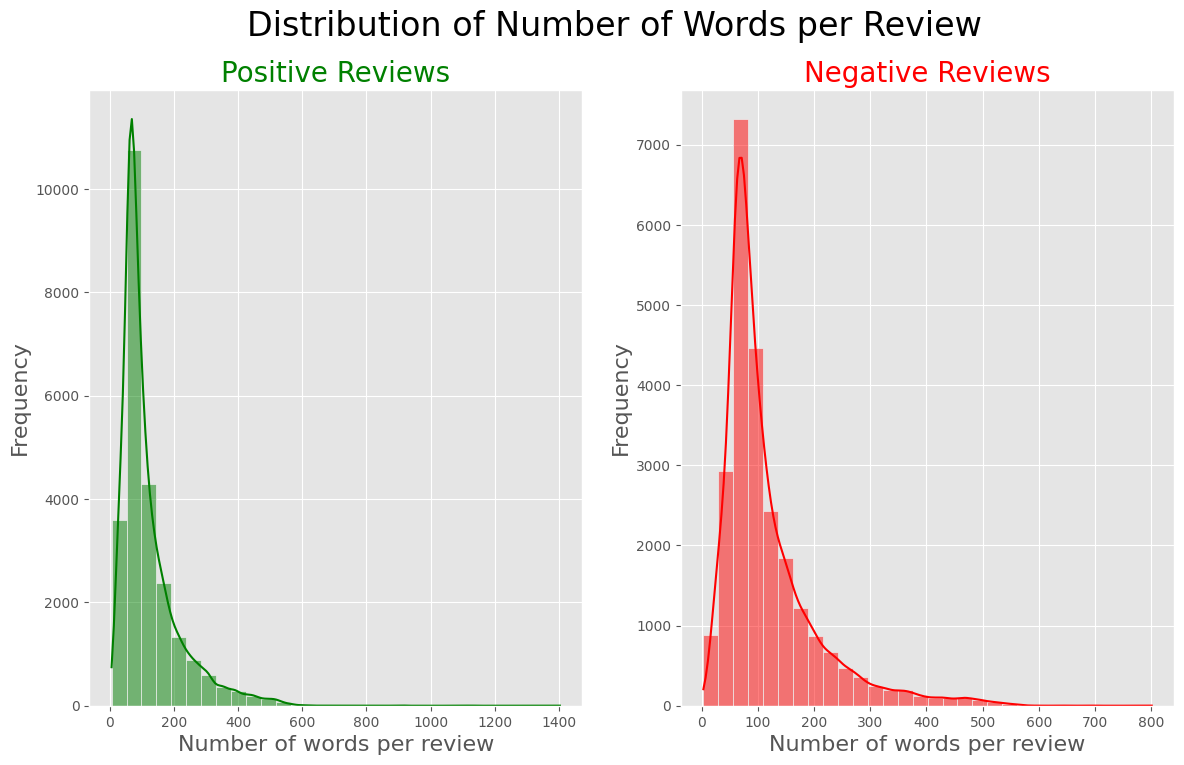

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

positive_word_counts = positive_reviews.str.split().apply(len)
sns.histplot(positive_word_counts, ax=ax1, bins=30, kde=True, color="green")  
ax1.set_title("Positive Reviews", fontsize=20, color="green")  
ax1.set_xlabel("Number of words per review", fontsize=16)  
ax1.set_ylabel("Frequency", fontsize=16) 

negative_word_counts = negative_reviews.str.split().apply(len)
sns.histplot(negative_word_counts, ax=ax2, bins=30, kde=True, color="red")  
ax2.set_title("Negative Reviews", fontsize=20, color="red") 
ax2.set_xlabel("Number of words per review", fontsize=16) 
ax2.set_ylabel("Frequency", fontsize=16) 

fig.suptitle("Distribution of Number of Words per Review", fontsize=24)
plt.show()

**3.3. Most Frequent Words in Negative and Positive Reviews**

The 10 most common words in negative and positive comments are visualized



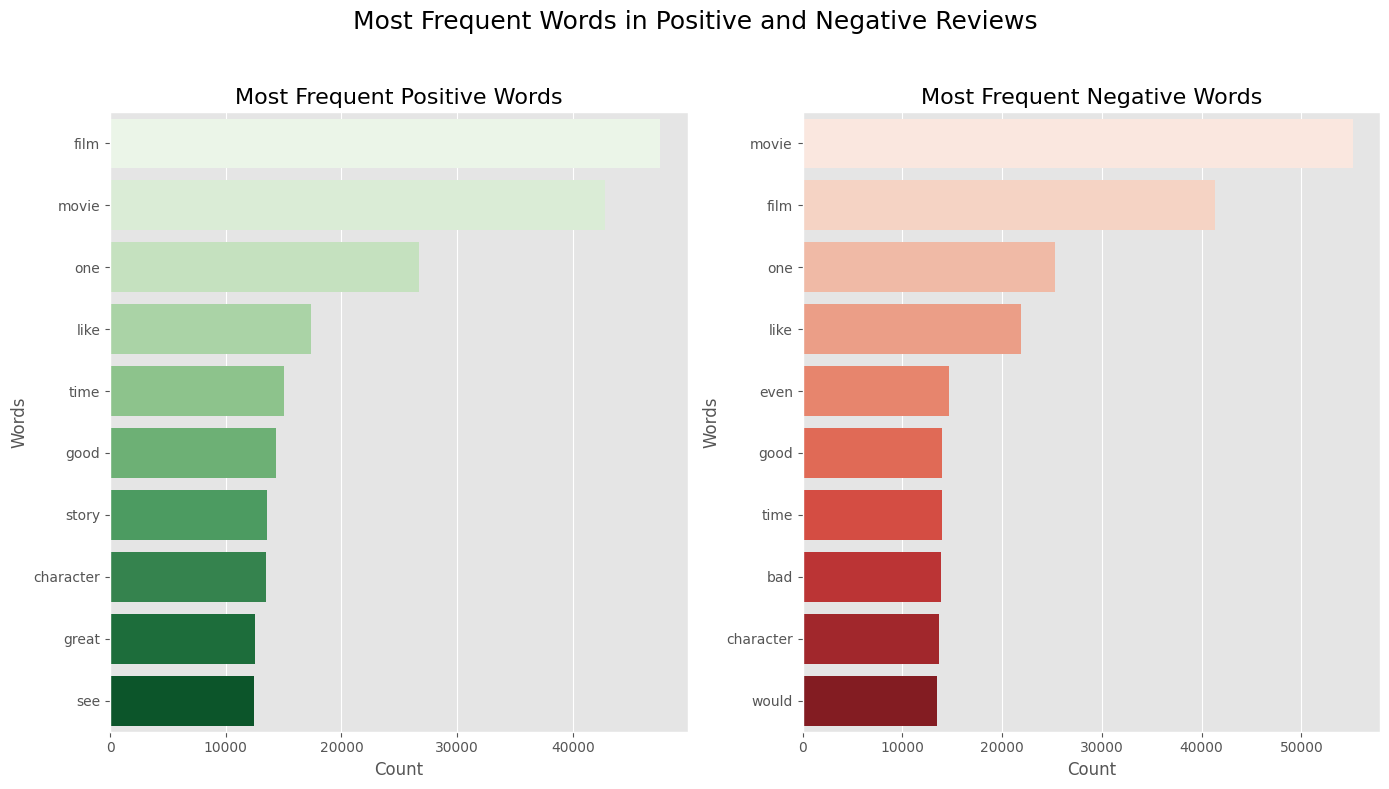

In [22]:
positive_words = positive_reviews.str.split(expand=True).stack().value_counts()
negative_words = negative_reviews.str.split(expand=True).stack().value_counts()

positive_top_words = positive_words.head(10).reset_index()
negative_top_words = negative_words.head(10).reset_index()

positive_top_words.columns = ['word', 'count']
negative_top_words.columns = ['word', 'count']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

sns.barplot(x='count', y='word', data=positive_top_words, ax=ax1, palette='Greens')
ax1.set_title('Most Frequent Positive Words', fontsize=16)
ax1.set_xlabel('Count', fontsize=12)
ax1.set_ylabel('Words', fontsize=12)

sns.barplot(x='count', y='word', data=negative_top_words, ax=ax2, palette='Reds')
ax2.set_title('Most Frequent Negative Words', fontsize=16)
ax2.set_xlabel('Count', fontsize=12)
ax2.set_ylabel('Words', fontsize=12)

plt.suptitle('Most Frequent Words in Positive and Negative Reviews', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### **4. Vectorization**

Vectorization is a crucial step in natural language processing (NLP) that transforms text data into numerical representations, enabling machine learning models to understand and process the information. Various methods are employed for vectorization, each with its unique characteristics and applications:

1. `Bag of Words (BoW)` 

    The Bag of Words method is a simple approach that represents text data based on the frequency of words. Each document is treated as a collection of words, and the frequency of each word is counted, resulting in vectors that ignore the order of words or grammatical structure.

2. `Term Frequency-Inverse Document Frequency (TF-IDF)`
   
   TF-IDF vectorization was developed to address some of the biases that could arise from Count vectorizer. By weighing the frequency of words against their importance in the document corpus, TF-IDF helps to mitigate the influence of commonly used words that may not carry significant meaning, thus providing a more nuanced representation of text data.


`N-Grams`

N-grams are a concept that is specific to text vectorization methods, including Count Vectorizer and TF-IDF Vectorizer.

Explanation:
 N-grams: An n-gram is a contiguous sequence of n items (words, characters, etc.) from a given text. For example:

- Unigrams: Single words (e.g., "happy", "sad").
- Bigrams: Pairs of consecutive words (e.g., "very happy", "not good").
- Trigrams: Triplets of consecutive words (e.g., "not very happy").
    
Both Count Vectorizer and TF-IDF Vectorizer can use n-grams to capture the relationships and context between words, enhancing the representation of text data for machine learning tasks. This allows the models to take into account phrases or specific word combinations rather than treating each word as an isolated feature.


3. `Word Embeddings`

Word embeddings are a powerful technique that represents words in a continuous vector space. Unlike traditional methods, they capture richer meanings by considering the context in which words appear.

In deep learning models, particularly in recurrent neural networks (RNNs) like LSTM, word embeddings play a crucial role. LSTMs are designed to process sequences of data, allowing them to understand relationships between words. For instance, when evaluating phrases like "not good" versus "very good," understanding the interactions between words helps make more accurate predictions.

Additionally, pre-trained word embeddings like Word2Vec and GloVe can be utilized to initialize the embedding layer of the LSTM model. This transfer learning approach can significantly improve model performance, especially in scenarios with limited training data.

In summary, word embeddings serve as a bridge between discrete words and continuous representations, enhancing the ability of models like LSTMs to comprehend complex language structures and semantics.




### **5. Sentiment Modelling**

Sentiment analysis has evolved significantly from its inception to the present day. Initially, the field relied on rule-based systems and early machine learning models, such as Naive Bayes, Support Vector Machines (SVMs) and Xgboost. The introduction of deep learning brought advancements with Long Short-Term Memory (LSTM) networks, which improved the ability to process sequential data. The breakthrough came with the transformer architecture, which paved the way for models like BERT (Bidirectional Encoder Representations from Transformers) in 2018, allowing for a deeper understanding of language context. Currently, large language models (LLMs) are at the forefront, utilizing vast datasets and computational power to achieve unprecedented levels of accuracy in sentiment analysis. This study aims to cover these developments comprehensively, showcasing the journey of sentiment analysis over time.

---

**5.1 Sentiment Analysis with Machine Learning Models With Bag of Words and TF-IDF**

 Vectorization techniques have also evolved over time. These techniques include Bag of Words, TF-IDF, and currently the most widely used, Word Embeddings. This section aims to train a classification model using Logistic Regression and Naive Bayes, incorporating Count Vectorizer and TFIDF Vectorizer. The importance of vectorization is emphasized here, and since each vectorization technique requires separate hyperparameter tuning, this process can be time-consuming. Therefore, hyperparameter tuning has not been included in this section.


Before we begin, we convert our target variable, sentiment, into a numerical format, with positive sentiments represented as 1 and negative sentiments as 0.

In [23]:
df["sentiment"] = np.where(df["sentiment"] == "positive", 1 , 0)
df["sentiment"].value_counts()

sentiment
1    24883
0    24696
Name: count, dtype: int64

**Split data as train and test**

In [138]:
feature = "review"
target = "sentiment"
X = df[feature]
y= df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [25]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(39663,) (9916,)
(39663,) (9916,)


**5.1.1. Bag of Words (BoW)**

The default value of unigrams was used to shorten the training time.

In [26]:
bow_vectorizer = CountVectorizer(ngram_range=(1,1)).fit(X_train)
x_train_bow = bow_vectorizer.transform(X_train)
x_test_bow = bow_vectorizer.transform(X_test)

In [27]:
print(x_train_bow.shape, X_test.shape)
print(x_test_bow.shape, y_test.shape)

(39663, 191484) (9916,)
(9916, 191484) (9916,)


**LogisticRegression model with Bag of Words vectorizing**

Train cross validation score: 0.88
Final test score: 0.88


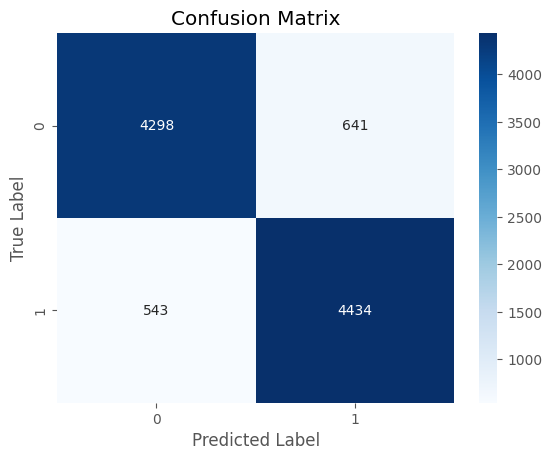

In [28]:
lr_model_bow = LogisticRegression(C= 1, penalty="l2", solver="lbfgs")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lr_model_trained_bow = train_and_evaluate_model(lr_model_bow, x_train_bow, y_train, x_test_bow, y_test, "accuracy", accuracy_score, skf)

**Prediction From Test Set**

In [29]:
random_review = pd.Series(X_test.sample(1).values)
predict_sentiment(model=lr_model_trained_bow, vectorizer=bow_vectorizer, review= random_review)

Review:  
bored television director introduced black art astral projection girlfriend learning ability separate spirit body man find renewed interest life sense wellbeing unfortunately man discovers sleeping spirit leaf body uncontrolled body roams street murderous rampage according dvd sleeve synopsisthe synopsis isnt entirely correct turn outanyway movie open dizzying outofbody example handsome director winston rekert paul sharpes newly discovered astral body experience also foreshadows upcoming dogfight young andrew bednarski matthew sharpe kid draw picture blue man murder spree begin handsome detective john novak stewart kaufman discovers victim connected mr rekert mr novaks investigation lead supernatural prime example karen black janus rekert fear falling loveseveral cast perform well blue man wind tying knot aka eternal evil unsatisfying story try far clever good 

 Prediction: positive


**Prediction From Sample Test Set**

First 3 reviews are positive and last 3 reviews are negative

In [30]:
sample_reviews = [
    "This movie was an absolute masterpiece! The storyline was captivating and the acting was phenomenal.",
    "I thoroughly enjoyed the film! The characters were relatable and the plot kept me engaged from start to finish.",
    "An incredible cinematic experience! The visuals were stunning, and the soundtrack perfectly complemented the story.",
    "Unfortunately, this film was quite disappointing. The plot was predictable and lacked depth.",
    "I was really bored throughout the movie. It felt too long, and the pacing was very slow.",
    "This movie had potential, but it failed to deliver. The acting was subpar and the dialogue was cringeworthy."
]
sample_reviews_df = pd.DataFrame(sample_reviews, columns=["review"])

In [31]:
df_samples_clean= text_preprocessing(sample_reviews_df, "review")
df_samples_clean_list = pd.Series(df_samples_clean["review"]).tolist()
for review in df_samples_clean_list:
    predict_sentiment(model=lr_model_trained_bow, vectorizer=bow_vectorizer, review= review)
    print(50 * "*")

WordNet is already downloaded.
Review:  
movie absolute masterpiece storyline captivating acting phenomenal 

 Prediction: positive
**************************************************
Review:  
thoroughly enjoyed film character relatable plot kept engaged start finish 

 Prediction: positive
**************************************************
Review:  
incredible cinematic experience visuals stunning soundtrack perfectly complemented story 

 Prediction: positive
**************************************************
Review:  
unfortunately film quite disappointing plot predictable lacked depth 

 Prediction: negative
**************************************************
Review:  
really bored throughout movie felt long pacing slow 

 Prediction: negative
**************************************************
Review:  
movie potential failed deliver acting subpar dialogue cringeworthy 

 Prediction: negative
**************************************************


**Naive Bayes model with Bag of Words vectorizing**

Train cross validation score: 0.85
Final test score: 0.85


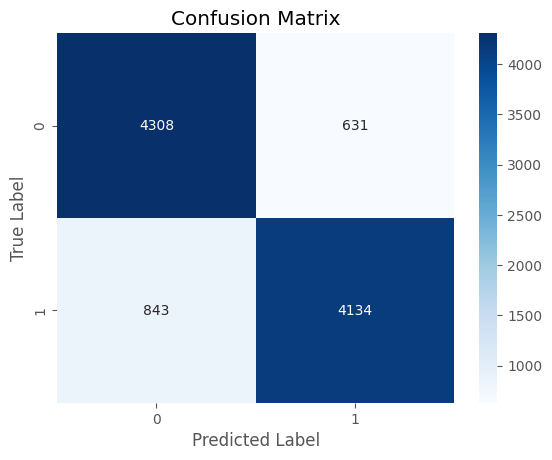

MultinomialNB(alpha=1)

In [32]:
nb_model_bow = MultinomialNB(alpha=1)
train_and_evaluate_model(nb_model_bow, x_train_bow, y_train, x_test_bow, y_test, "accuracy", accuracy_score, skf)

**Prediction From Test Set**

In [33]:
random_review = pd.Series(X_test.sample(1).values)
predict_sentiment(model=nb_model_bow, vectorizer=bow_vectorizer, review= random_review)

Review:  
beenoadcast bbc absolutely delighted seen credit rolled cast alone made certain would give go five minute completely immersed beautiful filmyes formulaic predictable somehow added charm flashback forty wonderfully placed captured feeling equalled productionsa real feelgood film punctuated throughout outstanding music released ill buy 

 Prediction: positive


**Prediction From Sample Test Set**

In [34]:
for review in df_samples_clean_list:
    predict_sentiment(model=nb_model_bow, vectorizer=bow_vectorizer, review= review)
    print(50 * "*")

Review:  
movie absolute masterpiece storyline captivating acting phenomenal 

 Prediction: positive
**************************************************
Review:  
thoroughly enjoyed film character relatable plot kept engaged start finish 

 Prediction: positive
**************************************************
Review:  
incredible cinematic experience visuals stunning soundtrack perfectly complemented story 

 Prediction: positive
**************************************************
Review:  
unfortunately film quite disappointing plot predictable lacked depth 

 Prediction: negative
**************************************************
Review:  
really bored throughout movie felt long pacing slow 

 Prediction: negative
**************************************************
Review:  
movie potential failed deliver acting subpar dialogue cringeworthy 

 Prediction: negative
**************************************************


**5.1.1. Term Frequency-Inverse Document Frequency (TF-IDF)**

In [35]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1)).fit(X_train)
x_train_tfidf = tfidf_vectorizer.transform(X_train)
x_test_tfidf = tfidf_vectorizer.transform(X_test)

In [36]:
print(x_train_tfidf.shape, X_test.shape)
print(x_test_tfidf.shape, y_test.shape)

(39663, 191484) (9916,)
(9916, 191484) (9916,)


**LogisticRegression model with TFIDF vectorizing**

Train cross validation score: 0.89
Final test score: 0.89


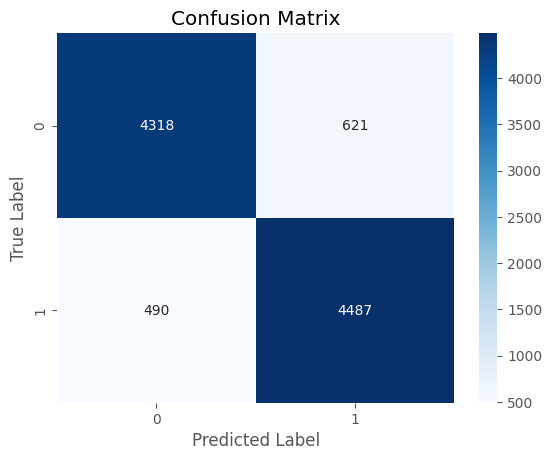

In [37]:
lr_model_tfidf = LogisticRegression(C= 1, penalty="l2", solver="lbfgs")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lr_model_trained_tfidf = train_and_evaluate_model(lr_model_tfidf, x_train_tfidf, y_train, x_test_tfidf, y_test, "accuracy", accuracy_score, skf)

**Prediction From Test Set**

In [38]:
random_review = pd.Series(X_test.sample(1).values)
predict_sentiment(model=lr_model_trained_tfidf, vectorizer=tfidf_vectorizer, review= random_review)

Review:  
fauxrussian scientist say twothirds way movie came science pretty much sum reason watched movie anything involves halfman halfhammerhead shark definitely deserves serious empirical investigation part impartial aspiring scientist say biz girlfriendsother remote rest history say special effect bad would disservice field special effect hard film car scene without cheesy bluescreen background yeah charming state art hitchcock filming bird look low budget spare cheap attempt scifi service actually making attempt willing suspension disbeliefhowever seriously defamed overall concept film let tell sad may sound probably worth time nothing else tour de force bad scifi worth education new movie buff certainly worthy refresher course seen movie daythe crazy hunchback mad scientist hammerhead transceiver think good idea spoon canful blood nearby water make question intelligence mankind also ability b movie writer come remotely plausible plot linesthis film also pretty much fulfills one l

**Prediction From Sample Test Set**

We are using same sample dataset before

In [39]:
for review in df_samples_clean_list:
    predict_sentiment(model=lr_model_trained_tfidf, vectorizer=tfidf_vectorizer, review= review)
    print(50 * "*")

Review:  
movie absolute masterpiece storyline captivating acting phenomenal 

 Prediction: positive
**************************************************
Review:  
thoroughly enjoyed film character relatable plot kept engaged start finish 

 Prediction: positive
**************************************************
Review:  
incredible cinematic experience visuals stunning soundtrack perfectly complemented story 

 Prediction: positive
**************************************************
Review:  
unfortunately film quite disappointing plot predictable lacked depth 

 Prediction: negative
**************************************************
Review:  
really bored throughout movie felt long pacing slow 

 Prediction: negative
**************************************************
Review:  
movie potential failed deliver acting subpar dialogue cringeworthy 

 Prediction: negative
**************************************************


**Naive Bayes model with TFIDF vectorizing**

Train cross validation score: 0.86
Final test score: 0.86


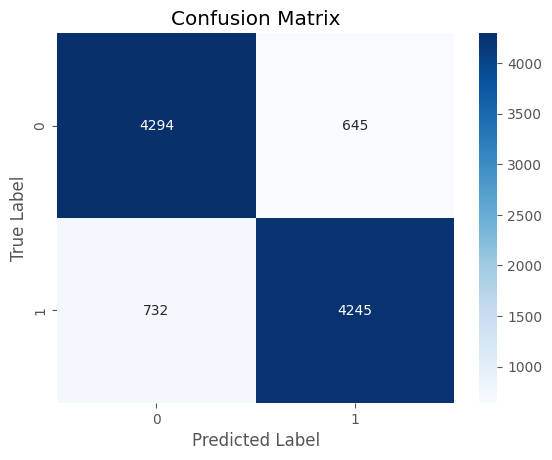

MultinomialNB(alpha=1)

In [40]:
nb_model_tfidf = MultinomialNB(alpha=1)
train_and_evaluate_model(nb_model_tfidf, x_train_tfidf, y_train, x_test_tfidf, y_test, "accuracy", accuracy_score, skf)

**Prediction From Test Set**

In [41]:
random_review = pd.Series(X_test.sample(1).values)
predict_sentiment(model=nb_model_tfidf, vectorizer=tfidf_vectorizer, review= random_review)

Review:  
homeward bound incredible journey one wonderful old movie house pet deserves place among great movie genre even cinema world general together animal movie like old yeller napoleon fluke air bud mean movie petscan possibly remake good remake know one heart since early teen year family movie treasure emotional thrilling adventurous exciting entertaining humorous charming sweet nostalgic beautiful heartwarming sometimes dramatic one movie put smile face appreciate kind filmsthis movie lack quality well thought story enjoyable character excellent relaxing instrumental soundtrack dazzling scenerieslandscapes magnificent sierra mountain oregon speaking vista mountain forest tree river waterfall sunset conclusion pure nature wonder truly full panoramathe main human character nice well developed well portrayed respective actor robert hay awesome kindhearted dad bob seaver kim greist good laura burnford veronica lauren equally good hope kevin chevalia conventional youngest cuteother j

**Prediction From Sample Test Set**

In [42]:
for review in df_samples_clean_list:
    predict_sentiment(model=nb_model_tfidf, vectorizer=tfidf_vectorizer, review= review)
    print(50 * "*")

Review:  
movie absolute masterpiece storyline captivating acting phenomenal 

 Prediction: positive
**************************************************
Review:  
thoroughly enjoyed film character relatable plot kept engaged start finish 

 Prediction: positive
**************************************************
Review:  
incredible cinematic experience visuals stunning soundtrack perfectly complemented story 

 Prediction: positive
**************************************************
Review:  
unfortunately film quite disappointing plot predictable lacked depth 

 Prediction: negative
**************************************************
Review:  
really bored throughout movie felt long pacing slow 

 Prediction: negative
**************************************************
Review:  
movie potential failed deliver acting subpar dialogue cringeworthy 

 Prediction: negative
**************************************************


**Result**

Logistic regression and Naive Bayes models were used as machine learning models in the IMDB sentiment analysis dataset. Logistic regression performed better as a model. Among the vectorization techniques, it was observed that the TF-IDF vectorizer method, which improves upon the limitations of BoW, provided better results.

In [43]:
result_dict = {
    "Vectorizer":["Bag Of Words", "Bag Of Words", "TF-IDF","TF-IDF"],
    "Model":["Logistic Regression","Naive Bayes", "Logistic Regression","Naive Bayes"],
    "CV Accuracy Score":[0.88, 0.85, 0.89, 0.86],
    "Test Accuracy Score":[0.88, 0.85, 0.89, 0.86],
}

result_df = pd.DataFrame(result_dict)
result_df

,Vectorizer,Model,CV Accuracy Score,Test Accuracy Score
0,Bag Of Words,Logistic Regression,0.88,0.88
1,Bag Of Words,Naive Bayes,0.85,0.85
2,TF-IDF,Logistic Regression,0.89,0.89
3,TF-IDF,Naive Bayes,0.86,0.86


**5.2 Sentiment Analysis with Deep Learning CNN & LSTM & Multi head Attention Model With Embeddings**

**Tokenization**

In the machine learning section, we utilized CountVectorizer and TF-IDF Vectorizers. These tools add all the words in the document as features and extract their frequencies, effectively tokenizing the text.

When training a deep learning model, we first need to perform the tokenization ourselves. Using the Tokenizer available in Keras, each review is broken down into tokens, and each token is assigned a number based on its frequency in the text.

To expedite the training process and obtain more accurate results, we can choose to use words that occur frequently in the dataset during the tokenization process. The dataset contains a total of 191,368 words. For the model, we will use the top 10,000 words with the highest frequencies, denoted as max_freq_words = 10000. Any words outside this set will be classified as `<oov> (out-of-vocabulary)`.

`tokenizer = Tokenizer(num_words = max_freq_words, oov_token="<oov>")`


Subsequently, these words are converted into numerical representations. However, a problem arises because the size of each review varies. To address this, we use the pad_sequences function, which fills in the missing words with zeros, ensuring that each input value has the same size. We can define the maximum size for each input during the padding sequence process.

To determine this maximum size, we first calculated the token size of all reviews in the training and test sets. We then averaged these sizes and added two standard deviations, resulting in a maximum length of `293`. This number represents `95%` of the entire dataset. We have now established the maximum number of features that will be input into the model.

In [44]:
max_freq_words = 10000
tokenizer = Tokenizer(num_words = max_freq_words, oov_token="<oov>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
total_vocabulary_size = len(word_index)
print(f"Total vocabulary of the dataset is : {total_vocabulary_size}")

Total vocabulary of the dataset is : 191368


In [45]:
train_review_sequences = tokenizer.texts_to_sequences(X_train)
test_review_sequences =  tokenizer.texts_to_sequences(X_test)

In [46]:
total_review_sequences_length_list = [len(i) for i in train_review_sequences + test_review_sequences]

In [47]:
max_review_sequence=max(total_review_sequences_length_list)
print(f"Maximum length of review sequence in the list is {max_review_sequence}")

Maximum length of review sequence in the list is 1403


In [48]:
pad_seq_max_len = np.mean(total_review_sequences_length_list) + 2 * np.std(total_review_sequences_length_list)
pad_seq_max_len = round(pad_seq_max_len)
print(f"Max length padding for pad_sequence function is {pad_seq_max_len}")

Max length padding for pad_sequence function is 296


In [49]:
cover_percentage= np.sum(np.array(total_review_sequences_length_list) < pad_seq_max_len) / len(total_review_sequences_length_list)*100
print(f"The maximum length calculated for the pad sequence function covers %{cover_percentage:.2f} of the reviews in the dataset.")

The maximum length calculated for the pad sequence function covers %94.53 of the reviews in the dataset.


**Word2Vec Training for Embeddings Matrix**

During the training phase of the model, an embeddings layer is added, and the weights for this layer are initialized randomly, initiating the learning process of the embedding layer.

To accelerate this process and enhance performance, we can leverage weights from another model through transfer learning. For this purpose, we use a pre-trained Word2Vec model, which we will fine-tune using our sentiment analysis dataset to obtain the weights that will then be fed into the embedding layer. The relevant function is provided in `utils.py`.

In [ ]:
vector_size = 128
total_vocabulary_size =  191368 
embedding_matrix = train_word2vec_and_get_embedding_matrix(X_train=X_train,
                                                           total_vocabulary_size = total_vocabulary_size,
                                                           vector_size=vector_size,
                                                           tokenizer=tokenizer)

**Preprocess Sentiment Data**

In the tokenization section, the preprocessing steps we performed to obtain the maximum pad sequence have been encapsulated into a function. Additionally, preprocessing has been carried out on the previously split train and test datasets before they are fed into the model.

In [ ]:
max_freq_words = 10000
pad_seq_max_len = 296

X_train_processed, X_test_processed = preprocess_sentiment_data(X_train=X_train, 
                                                               X_test=X_test,
                                                               most_freq_words=max_freq_words,
                                                               max_padding_length=pad_seq_max_len)

**CNN & LSTM & Multi Head Attention Model**

Since the created model requires intensive computation, training on a GPU will be faster. For this purpose, the working environment has been set up in WSL, and GPU verification has been conducted.

In [ ]:
print("TensorFlow version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Model açıklamaları

In [170]:
embedding_dim = 128
total_word_size = 191368
maxlen = 296
epochs = 50
batch_size = 32
validation_split = 0.2

result, model = sentiment_cnn_lstm_att_model(X_train=X_train_processed,
                                        y_train=y_train,
                                        total_word_size=total_word_size,
                                        embedding_dim=embedding_dim,
                                        maxlen=maxlen,
                                        batch_size=batch_size,
                                        validation_split=validation_split,
                                        epochs=epochs,
                                        embedding_matrix=embedding_matrix)

Epoch 1/50
992/992 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.7045 - loss: 0.5189
Epoch 1: val_loss improved from inf to 0.31662, saving model to ./model/best_model.keras
992/992 ━━━━━━━━━━━━━━━━━━━━ 408s 404ms/step - accuracy: 0.7046 - loss: 0.5188 - val_accuracy: 0.8693 - val_loss: 0.3166 - learning_rate: 0.0010
Epoch 2/50
992/992 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.9038 - loss: 0.2366
Epoch 2: val_loss improved from 0.31662 to 0.27619, saving model to ./model/best_model.keras
992/992 ━━━━━━━━━━━━━━━━━━━━ 407s 410ms/step - accuracy: 0.9038 - loss: 0.2366 - val_accuracy: 0.8937 - val_loss: 0.2762 - learning_rate: 0.0010
Epoch 3/50
992/992 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.9295 - loss: 0.1815
Epoch 3: val_loss did not improve from 0.27619
992/992 ━━━━━━━━━━━━━━━━━━━━ 414s 417ms/step - accuracy: 0.9295 - loss: 0.1815 - val_accuracy: 0.8850 - val_loss: 0.2847 - learning_rate: 0.0010
Epoch 4/50
992/992 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9471

**Model Evaluation**

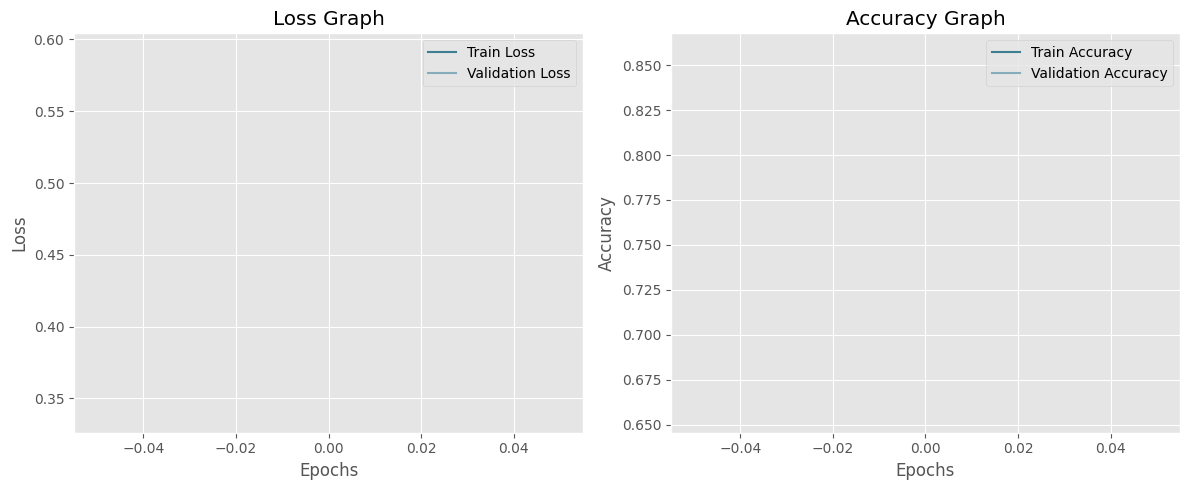

In [132]:
plot_training_history(result)

In [144]:
model = load_model("./model/best_model.keras")

In [145]:
def evaluate_model(model, X_train, y_train, X_test, y_test) -> None:
    """
    Evaluates the performance of the given model on the training and testing data.
    
    Parameters
    ----------
    model : keras.Model
        The trained Keras model to evaluate.
        
    X_train : np.ndarray
        The training input data.
        
    y_train : np.ndarray
        The true labels for the training data.
        
    X_test : np.ndarray
        The testing input data.
        
    y_test : np.ndarray
        The true labels for the testing data.
        
    Returns
    -------
    None
    """
    
    # Training accuracy
    train_loss, train_accuracy = model.evaluate(X_train, y_train)
    print(f"Training Accuracy: {train_accuracy:.4f}")
    
    # Testing accuracy
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5).astype(int)  # Binarize predictions
    
    # Confusion Matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    
    # Plotting the Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

310/310 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.8871 - loss: 0.2721


[0.27572914958000183, 0.8861436247825623]

In [ ]:
evaluate_model(model, X_train_processed, y_train, X_test_processed, y_test)

310/310 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step


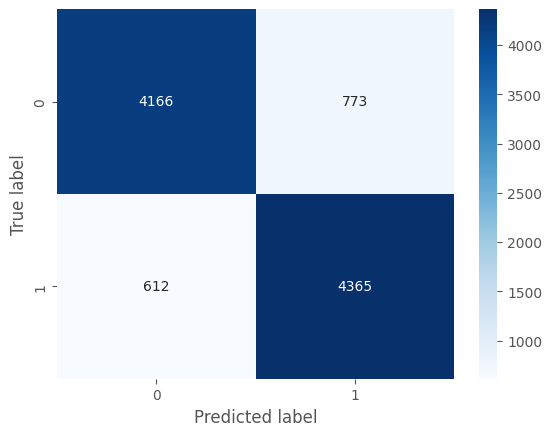

In [136]:
model.evaluate(X_test_processed,y_test)
ypred = model.predict(X_test_processed)
ypred = ypred>0.5

cf_matrix = confusion_matrix(y_test, ypred)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
# def sentiment_lstm_cnn_model(X_train,
#                              y_train,
#                              total_word_size,
#                              embedding_dim,
#                              maxlen,
#                              batch_size,
#                              validation_split,
#                              epochs,
#                              embedding_matrix):

#     i = Input(shape=(maxlen,))
#     x = Embedding(total_word_size + 1, 
#                   embedding_dim, 
#                   input_length = maxlen,
#                   weights=[embedding_matrix])(i)
#     x = BatchNormalization()(x)
#     x = Dropout(0.4)(x)
    

#     x = Conv1D(32, 5, activation='relu')(x)

#     x = MaxPooling1D(2)(x)
#     x = Dropout(0.5)(x)

#     x = Bidirectional(LSTM(128,return_sequences=True))(x)
    
#     x = Attention()([x, x])
    
#     x = GlobalMaxPooling1D()(x)

#     x = Dense(1, activation='sigmoid')(x)
#     model = Model(i, x)
    
    
#     optimizer = Adam(learning_rate=0.001)
#     model.compile(optimizer=optimizer ,
#               loss='binary_crossentropy',
#               metrics=['accuracy'])
    
#     checkpoint_callback = ModelCheckpoint(
#         filepath="./model/best_model.keras",  
#         monitor="val_loss",
#         save_best_only=True,  
#         save_weights_only=False,
#         mode="min",
#         verbose=1
#         )
        
#     early_stopping_callback = EarlyStopping(
#         monitor="val_loss",
#         patience=3,  
#         verbose=1
#     )

#     lr_callback = ReduceLROnPlateau(
#         monitor='val_loss', 
#         factor=0.3, 
#         patience=2,
#         min_lr = 0.00001,
#         verbose=1) 
    
#     result = model.fit(X_train,y_train, 
#                   validation_split= validation_split,
#                   epochs = epochs, 
#                   batch_size = batch_size,
#                   callbacks = [checkpoint_callback,early_stopping_callback,lr_callback])
    

#     return result, model